# déneigeuse application

Après avoir explicité la théorie, nous cherchons maintenant l'appliquer à un cas concrêt à la ville de monréal. Le but est de répartir les taches entre les différentes déneigeuses dans le but de parcourir Montréal le plus efficacement possible.

## Mise en place de l'application

In [257]:
#IMPORT
import osmnx as ox
import networkx as nx
import numpy as np
import multiprocessing as mp
import sys
sys.path.append("../scripts")
import deneigeuse_functions as df
import simplify_vertices as sv

Le code ci-dessous est mis en commentaire dans le but d'éviter de récréer les graph à chaque fois, ce qui prend beaucoup de temps.

In [9]:

G_1 = ox.load_graphml('../data/graph.graphml')
G_2 = ox.load_graphml('../data/graph2.graphml')
G_3 = ox.load_graphml('../data/graph3.graphml')
G_4 = ox.load_graphml('../data/graph4.graphml')
G_5 = ox.load_graphml('../data/graph5.graphml')
G_6 = ox.load_graphml('../data/graph6.graphml')
G_7 = ox.load_graphml('../data/graph7.graphml')
G_8 = ox.load_graphml('../data/graph8.graphml')
G_9 = ox.load_graphml('../data/graph9.graphml')
G_10 = ox.load_graphml('../data/graph10.graphml')
G_11 = ox.load_graphml('../data/graph11.graphml')
G_12 = ox.load_graphml('../data/graph12.graphml')
G_13 = ox.load_graphml('../data/graph13.graphml')
G_14 = ox.load_graphml('../data/graph14.graphml')
G_15 = ox.load_graphml('../data/graph15.graphml')
G_16 = ox.load_graphml('../data/graph16.graphml')
G_17 = ox.load_graphml('../data/graph17.graphml')
G_18 = ox.load_graphml('../data/graph18.graphml')
G_19 = ox.load_graphml('../data/graph19.graphml')

L = [G_1, G_2, G_3, G_4, G_5, G_6, G_7, G_8, G_9, G_10, G_11, G_12, G_13, G_14, G_15, G_16, G_17, G_18, G_19]

#ox.plot_graph(G_1)

Notre idée ici est de séparer Montreal en fonction de ses 19 arrondissements, cela permet d'éviter le chevauchement entre deux zones, même si évidément des zones peuvent partager des routes. De plus cela permet une répartition optimale des déneigeuses.

In [226]:
def decomplexify(graph):
    node_list = graph.edges(data=True)
    to_graph = nx.Graph()
    for node in node_list:
        #Weight
        dist = node[2]["length"]
        n1 = node[0]
        n2 = node[1]
        #Oriented graph
        to_graph.add_edge(n1, n2, weight = dist) 
    return to_graph

def to_gnx(graph):
    gnx = nx.Graph()
    for (a,b,c) in graph:
        gnx.add_edge(a,b, weight=c)
    return gnx

def decomplexify_tograph(osmnx):
    node_list = graph.edges(data=True)
    to_graph = []
    for node in node_list:
        #Weight
        dist = node[2]["length"]
        n1 = node[0]
        n2 = node[1]
        #Oriented graph
        to_graph.append(n1, n2, dist)
    return to_graph
    

La fonction prend en entrée une liste de noeud avec plein d'informations qui ne nous sont pas forcément utiles. Le but ici est de  servir de la bibliothèque networkx qui nous donne accés à  plein de fonction pour nous facilier la tache sur les graph.

## MISE  EN PLACE DU DECOUPAGE
    

Le but ici est de séparer nos 19 arrondissements en zone qui pourront être attribuées à une déneigeuse. Soyons plus formel, nous disposons de 2200 déneigeneuses. Nous partons du principe que nous avons besoin de deux groupes de déneigeuse, un groupe pour le trottoir et un pour la route. Ce qui nous fais 1100 paires engins route et trottoir, sachant nous avons 19 arrondissement. Toutefois, tous les arrondissement n'ont pas la même longueur de rue totale, il faut donc attribuer n machines par arrondissement proportionellement à la longueur sur la longueur totale de rue de Montreal. De plus, après de nombreux test nous sommes apperçu que 1100 paires de machines était bien trop pour être attribué à une zone. Donc nous aurons deux paires de machines par zone qui  ne travaillerons évidement pas en même temps. La ville peut donc mettre en place un système de rotation. Il faut donc **découper nos 19 arrondissements en n zones**.

S'ils l'ont se place du point de vue de la théorie des graph cela n'est pas vraiment un découpage car cela reviendrais à supprimer des routes. Non, il faut donc mettre en place un algorithme qui regroupe les sommets du graph en communauté.

In [74]:
def edge_to_remove(g):
      
    d1 = nx.edge_betweenness_centrality(g)
    list_of_tuples = d1.items()
    max_edge = ()
    for key, value in sorted(list_of_tuples, key = lambda x:x[1], reverse = True):
        max_edge = key
        break
    
    return max_edge

def girvan_newman(g):
    connect_comp = nx.connected_components(g)
    lena = nx.number_connected_components(g)
    edges = g.edges()
    L_rem = []
    while (lena == 1):
        u, v = edge_to_remove(g)
        L_rem.append((u,v,edges[(u,v)]['weight']))
        g.remove_edge(u, v) 
        connect_comp = nx.connected_components(g)
        lena=nx.number_connected_components(g)
    return (connect_comp, L_rem)

Pour créer des zones dans le graph nous avons décidé d'utiliser l'algorithme de Girvan Newman. Ce derniers à pour objectif de créer des communautés de noeud basée sur la centralité intermédiaire ou Betweenness centrality, qui peut se définir comme la centralité d'un noeud ou d'une arête dans un graph. Elle se calcule par le nombre de plus court chemins passant par cette arête entre deux noeud d'un graph et donc une arête avec une centralité intermédiaire élevée a donc une grande importance dans le transfert de donnés dans un réseau.

### explication de l'algorithme de Girvan Newman

1. On cherche l'arête à supprimer en cherchant celle qui a centralité intermédiaire la plus importante
2. On supprime cette arête
3. On réitère tant qu'il n'y a pas plusieurs communauté autrement dit plusieurs composantes connexes
4. On recalcule centralité intermédiaire, cela nous permet de nous assurer qu'au  moins une arrête à une centralité intermédiaire importante entre deux communautés

In [75]:
#Return a list of graph_nx witch match the component
def component_to_graph(components, graph_nx):
    graph_list = []
    for component in components[0]:
        graph_list.append(nx.subgraph(graph_nx, component).copy())
    #for (a, b, c) in components[1]:
     #   graph_list[0].add_edge(a,b, weight=c)
    return graph_list    

In [76]:
def split_in_two(graph_nx):
    L = component_to_graph(girvan_newman(graph_nx.copy()), graph_nx)
    R1 = []
    R2 = []
    #Convert to classical representation
    for u in L[0].edges(data=True):
        R1.append((u[0],u[1],u[2]['weight']))
    for u in L[1].edges(data=True):
        R2.append((u[0],u[1],u[2]['weight']))
    return (R1, R2)
    

Les 3 fonctions ci-dessous nous permettent d'attribuer proportionnellement un nombre de machine en fonction de la longueur de l'arrondissement en question

In [235]:
def get_total_lenght(L):
    summ=0
    for g in L:
        for node in g.edges(data=True):
            summ+=node[2]["length"]
    return summ             

In [198]:
def get_lenght_graph(G):
    summ  =0
    for node in G.edges(data=True):
        summ+=node[2]['weight']
    return summ

In [199]:
def get_machine_number(gnx, L):
    total = get_total_lenght(L)
    len_graph = get_lenght_graph(gnx)
    perc = (len_graph * 100) / total
    return int((perc/100) * 1100)

Pour apporter le plus de précision voici le nombre de (paires) de machines calculés pour chaque  arrondissement :

In [237]:
count = 0
for i in  range(len(L)):
    tmp = get_machine_number(decomplexify(L[i]), L)
    count+=tmp
    print("Nombre de machines pour l'arrondissement "+str(i+1)+" : "+str(tmp))    

Nombre de machines pour l'arrondissement 1 : 32
Nombre de machines pour l'arrondissement 2 : 28
Nombre de machines pour l'arrondissement 3 : 19
Nombre de machines pour l'arrondissement 4 : 43
Nombre de machines pour l'arrondissement 5 : 14
Nombre de machines pour l'arrondissement 6 : 50
Nombre de machines pour l'arrondissement 7 : 14
Nombre de machines pour l'arrondissement 8 : 7
Nombre de machines pour l'arrondissement 9 : 44
Nombre de machines pour l'arrondissement 10 : 20
Nombre de machines pour l'arrondissement 11 : 36
Nombre de machines pour l'arrondissement 12 : 9
Nombre de machines pour l'arrondissement 13 : 14
Nombre de machines pour l'arrondissement 14 : 17
Nombre de machines pour l'arrondissement 15 : 4
Nombre de machines pour l'arrondissement 16 : 68
Nombre de machines pour l'arrondissement 17 : 36
Nombre de machines pour l'arrondissement 18 : 42
Nombre de machines pour l'arrondissement 19 : 37


La fonction ci-dessous permet le découpage en n graph en fonction de que nous renvoie get_machine_number.

In [209]:
def split_in_n(graph_nx):
    count = 1
    sub_graphs = [graph_nx]
    sub_graph_result = [None]
    print("[+] Start spliting")
    machine_num = get_machine_number(graph_nx, L)
    print("[+] Machine number for this zone : "  + str(machine_num))
    while (count < machine_num):
        graph_nx_  =  sub_graphs.pop(0)
        (graph1, graph2) = split_in_two(graph_nx_)
        if (len(graph1) > 0):
            sub_graph_result.append(graph1)
            sub_graphs.append(to_gnx(graph1))
        if (len(graph2) > 0):
            sub_graph_result.append(graph2)
            sub_graphs.append(to_gnx(graph2))
        sub_graph_result.pop(0)
        count += 1
    print("[-] Done spliting")
    print("Expected number : " + str(machine_num) + " Size of list : "+str(len(sub_graph_result)))
    return sub_graph_result

### EXPLICATION DU DECOUPAGE

C'est l'étape qui va nous permettre de séparer la ville en zone.

1. Mise en place de deux queue une qui sert pour le résultat, l'autres les calculs
2. Tant que l'on a pas le nombre de zone désiré on divise le graph en deux à l'aide de l'algorithme de Givann Newman
3. On vérifie que le graph n'est pas vide car il se peut que girvan newmann nous donne une composenante connexe à un seul noeud.
4. On ajoute les deux graph à la queue
5. On pop le graph du résultat qui vient d'être split en deux

In [180]:
gnxr = decomplexify(G_1)

Exemple de découpage de l'arrondissement numéro 1 en n zones qui comme expliqué avant sont calculés proportionnellement (list de n graph) :

In [200]:
nxet = split_in_n(gnxr)

In [3]:
# La fonction si dessous sauvegarde le résultat obtenue dans le but d'éviter des calculs long

import pickle

def split_and_save(G, filename):
    sub_graphs = split_in_n(decomplexify(G), 55)
    with open(filename, "wb") as f:
        pickle.dump(sub_graphs, f)
        


In [201]:
nxe = []

#cela nous permet directement de charger la liste de n graph sans passer par les calculs
with open("../data/graph1.txt", "rb") as f:
    nxe = pickle.load(f)

On vérifie la taille de la liste obtenue qui est bien égale à ce qui était calculé par get_machine_number :

In [203]:
print(len(nxe) == get_machine_number(gnxr, L))

True


Le code ci dessous met en évidence un des graphs calculés de la list obtenue pour l'arrondissement 1 :

In [114]:
R1 = []
for (a,b,c) in nxe[3]:
    R1.append((a,b))

In [118]:
ec = ['b' if (u,v) in R1 or (v,u) in R1  else 'r' for u, v, k in G_1.edges(keys=True)]

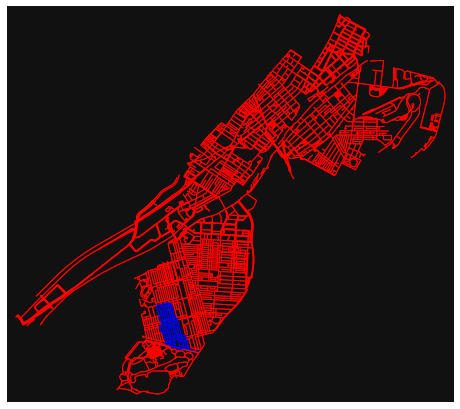

In [119]:
fig, ax = ox.plot_graph(G_1, node_color='w', node_edgecolor='k', node_size=0, 
                           node_zorder=3, edge_color=ec, edge_linewidth=1)

### APPLICATION SUR TOUS LES SOUS GRAPH

On va maintenant relier cette partie avec les fonction créées dans la partie application pour trouver le chemin le plus optimisé.

In [204]:
'''
Pour chaque sous graph on appelle la fonction pour obtenir le chemin à parcourir pour chaque zone
de l'arrondissement et on ajoute une couleur aléatoire
'''

def get_paths(g_list):
    path = [df.get_path_from_graph(G) for G in g_list if len(G) !=0]
    color = ['#%02x%02x%02x' % (tuple(np.random.choice(range(256), size=3))) for G in g_list if len(G) !=  0]
    return (color,path)
    


In [206]:
(color1, path2) = get_paths(nxet)

Voici ci-dessous l'arrondissement 1 avec ses 32 zones dont la couleur de chaque est le chemin parcouru par la paire de machine :

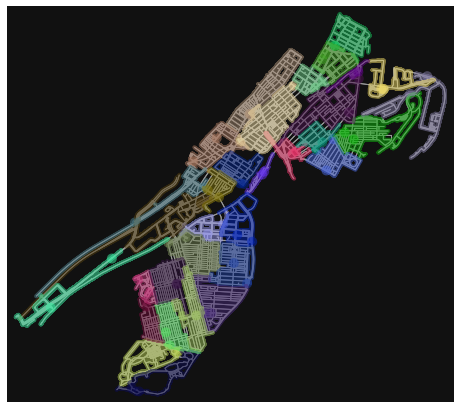

In [184]:
fig, ax = ox.plot_graph_routes(G_1, path2, route_colors=color1,route_linewidth=6, node_size=0)

Voici l'arrondissement 15 :

In [212]:
nx1 = split_in_n(decomplexify(G_15))


(color2, path3) = get_paths(nx1)

[+] Start spliting
[+] Machine number for this zone : 4
[-] Done spliting
Expected number : 4 Size of list : 4


In [267]:
#save the subgraph
with open("../data/graph15.txt", "wb") as f:
    pickle.dump(nx1, f)

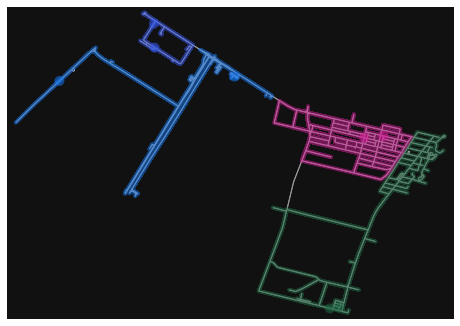

In [215]:
fig, ax = ox.plot_graph_routes(G_15, path3, route_colors=color2,route_linewidth=6, node_size=0)

L'arrondissement 8 :

In [239]:
nx2 = split_in_n(decomplexify(G_8))

[+] Start spliting
[+] Machine number for this zone : 7
[-] Done spliting
Expected number : 7 Size of list : 7


In [265]:
with open("../data/graph8.txt", "wb") as f:
    pickle.dump(nx2, f)

In [241]:
(color3, path4) = get_paths(nx2)

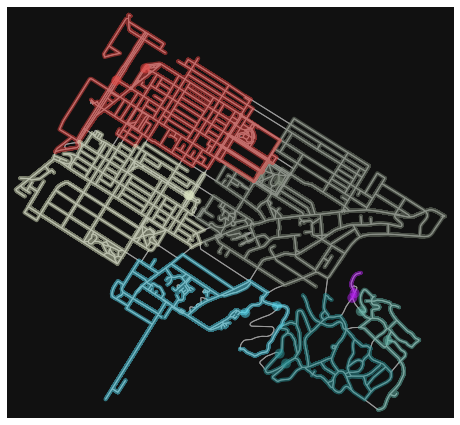

In [242]:
fig, ax = ox.plot_graph_routes(G_8, path4, route_colors=color3,route_linewidth=6, node_size=0)

L'arrondissement 10 :

In [247]:
nx3 = split_in_n(decomplexify(G_10))

[+] Start spliting
[+] Machine number for this zone : 20
[-] Done spliting
Expected number : 20 Size of list : 20


In [266]:
with open("../data/graph10.txt", "wb") as f:
    pickle.dump(nx3, f)

In [248]:
(color4, path5) = get_paths(nx3)

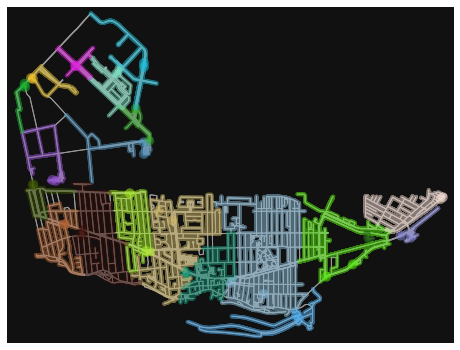

In [249]:
fig, ax = ox.plot_graph_routes(G_10, path5, route_colors=color4,route_linewidth=6, node_size=0)

### ANALYSE DES RESULTAT

In [250]:
# Calculating the path length and the total zone roads length
def calc_city_length(G):
    l = 0
    for (n1, n2, w) in G:
        l += w
    return l

def calc_path_length(G, path):
    total = 0.
    in_reverse = 0
    in_normal = 0
    for i in range(len(path) - 1):
        first = path[i]
        second = path[i + 1]
        flag = False
        for (a, b, w) in G:
            if (a == first and b == second):
                in_normal += 1
                total = total + w
                flag = True
                break
        if (flag == False):
            for (a, b, w) in G:
                if (b == first and a == second):
                    in_reverse += 1
                    total = total + w
                    flag = True
                    break
        if (flag == False):
            print("The path or the graph are not correct")
    return total

In [261]:
nx_g1 = []

#cela nous permet directement de charger la liste de 55 graph sans passer par les calculs
with open("../data/graph1.txt", "rb") as f:
    nx_g1 = pickle.load(f)

In [262]:
def calc_average_lengths(Gs):
    lG, lP = 0, 0
    count = 0
    for i in range(len(Gs)-1):
        g = Gs[i]
        if (len(g) < 150):
            count += 1
            G_copy = g.copy()
            extracted = sv.extract_vertices(g)
            new_real_G = sv.replace_vertices(g, extracted)
            G_eul = df.directed_to_eulerian(new_real_G)
            epath = df.get_eulerian_path(G_eul)
            path = df.replace_nodes(new_real_G, epath)
            lG += calc_city_length(new_real_G)
            lP += calc_path_length(new_real_G, path)
    return (count, lG, lP)

In [263]:
(count, a,b) = calc_average_lengths(nx_g1)
print("For", count, "zones, the total roads distance is", a, "and the total driven distance is", b)

For 12 zones, the total roads distance is 78098.408 and the total driven distance is 361605.936


On remarque que la distance totale parcourue par les deneigeuses pour visiter toutes les routes de la ville est toujours environ le double de la distance totale de toutes les routes.